### TASK 1 - Constructing the biomedical knowledge graph: 

In [93]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Loading the node data
nodes_df = pd.read_csv('hetionet-v1.0-nodes.tsv', sep='\t', header=0, names=['ID', 'Name', 'Kind'])

# Loading the edge data
edges_df = pd.read_csv('edges.sif', sep='\t', header=0, names=['Source', 'Metaedge', 'Target'])

#Creating the Graph
G = nx.MultiDiGraph()

#Adding nodes with ID as the node identifier
for _, row in nodes_df.iterrows():
    G.add_node(row['ID'], name=row['Name'], kind=row['Kind'])

# Adding edges
for _, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], type=row['Metaedge'])

# G is our graph structure containing nodes with their attributes and the edges between them

In [94]:
# Counting different types for nodes
node_kind = {node_attrs['kind'] for _, node_attrs in G.nodes(data=True)}

# Counting different types for edges
edge_types = {edge_attrs['type'] for _, _, edge_attrs in G.edges(data=True)}

# Creating H as the direct graph
H = G.to_directed()

print("Different types for nodes:", len(node_kind))
print("Different types for edges:", len(edge_types))

Different types for nodes: 11
Different types for edges: 24


### TASK 2 - Analyzing the biomedical knowledge graph:

In [95]:
# Counting nodes associated with each kind
node_counts = {}
for node, node_attrs in G.nodes(data=True):
    node_kind = node_attrs['kind']
    if node_kind not in node_counts:
        node_counts[node_kind] = 1
    else:
        node_counts[node_kind] += 1

# Counting edges associated with each type
edge_counts = {}
for _, _, edge_attrs in G.edges(data=True):
    edge_type = edge_attrs['type']
    if edge_type not in edge_counts:
        edge_counts[edge_type] = 1
    else:
        edge_counts[edge_type] += 1


#Here we list the Total Number of Entities for Each Unique Kind
print("Nodes associated with each kind:")
for node_kind, count in node_counts.items():
    print(f"{node_kind}: {count}")

#Here we list the Total Number of Edges for Each Unique Type
print("\nEdges associated with each type:")
for edge_type, count in edge_counts.items():
    print(f"{edge_type}: {count}")

Nodes associated with each kind:
Anatomy: 402
Biological Process: 11381
Cellular Component: 1391
Compound: 1552
Disease: 137
Gene: 20945
Molecular Function: 2884
Pathway: 1822
Pharmacologic Class: 345
Side Effect: 5734
Symptom: 438

Edges associated with each type:
AdG: 102240
AeG: 526407
AuG: 97848
CrC: 6486
CtD: 755
CbG: 11571
CuG: 18756
CcSE: 138944
CdG: 21102
CpD: 390
DdG: 7623
DpS: 3357
DlA: 3602
DrD: 543
DaG: 12623
DuG: 7731
GiG: 147164
GpCC: 73566
GpBP: 559504
GcG: 61690
GpMF: 97222
GpPW: 84372
Gr>G: 265672
PCiC: 1029


In [96]:
from collections import defaultdict

# Initializing dictionaries to sum degrees and count nodes for each kind
in_degrees = defaultdict(int)
out_degrees = defaultdict(int)
counts = defaultdict(int)

for node, attrs in H.nodes(data=True):
    node_kind = attrs['kind']
    counts[node_kind] += 1
    in_degrees[node_kind] += H.in_degree(node)
    out_degrees[node_kind] += H.out_degree(node)

# Calculating and printing average in/out-degrees
avg_in_degrees = {node_kind: in_deg / counts[node_kind] for node_kind, in_deg in in_degrees.items()}
avg_out_degrees = {node_kind: out_deg / counts[node_kind] for node_kind, out_deg in out_degrees.items()}

print("Average In-Degree for each node kind:")
for node_kind, avg_in in avg_in_degrees.items():
    print(f"{node_kind}: {avg_in}")

print("\nAverage Out-Degree for each node kind:")
for node_kind, avg_out in avg_out_degrees.items():
    print(f"{node_kind}: {avg_out}")

Average In-Degree for each node kind:
Anatomy: 8.960199004975124
Biological Process: 49.16123363500571
Cellular Component: 52.887131560028756
Compound: 4.842139175257732
Disease: 12.321167883211679
Gene: 61.1328240630222
Molecular Function: 33.71081830790569
Pathway: 46.30735455543359
Pharmacologic Class: 0.0
Side Effect: 24.231600976630624
Symptom: 7.664383561643835

Average Out-Degree for each node kind:
Anatomy: 1807.2014925373135
Biological Process: 0.0
Cellular Component: 0.0
Compound: 127.5798969072165
Disease: 258.97080291970804
Gene: 61.55120553831463
Molecular Function: 0.0
Pathway: 0.0
Pharmacologic Class: 2.982608695652174
Side Effect: 0.0
Symptom: 0.0


### 1. Ego Network (1-Degree Subgraph)

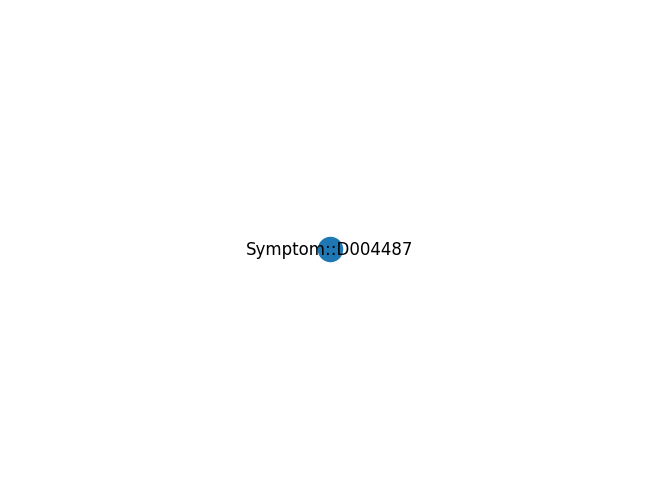

In [97]:
def extract_ego_network(G, node_id, radius=1):
    ego_net = nx.ego_graph(G, node_id, radius=radius)
    return ego_net

# Assuming `symptom_id` is the node ID for "Edema"
ego_net = extract_ego_network(H, symptom_id)
nx.draw(ego_net, with_labels=True)
plt.show()

### ANALYSIS:

For each “Disease” compute the number of connections (in-degree and out-degree) 
and show the most connected diseases. 

In [98]:
# Initialize dictionaries to store in-degree and out-degree for diseases
disease_connections = defaultdict(lambda: {'in': 0, 'out': 0})

# Here for each disease we find in and out degree
for node, attrs in H.nodes(data=True):
    if attrs['kind'] == 'Disease':
        disease_connections[node]['in'] = H.in_degree(node)
        disease_connections[node]['out'] = H.out_degree(node)

# and then we sort diseases by in-degree and out-degree
most_connected_by_in_degree = sorted(disease_connections.items(), key=lambda x: x[1]['in'], reverse=True)
most_connected_by_out_degree = sorted(disease_connections.items(), key=lambda x: x[1]['out'], reverse=True)

# top 5 most connected diseases by in-degree
print("Top 5 diseases by in-degree (most incoming connections):")
for disease, degrees in most_connected_by_in_degree[:5]:
    disease_name = H.nodes[disease]['name']  # Get the disease name
    print(f"{disease_name}: In-Degree = {degrees['in']}")

# top 5 most connected diseases by out-degree
print("\nTop 5 diseases by out-degree (most outgoing connections):")
for disease, degrees in most_connected_by_out_degree[:5]:
    disease_name = H.nodes[disease]['name']  # Get the disease name
    print(f"{disease_name}: Out-Degree = {degrees['out']}")


Top 5 diseases by in-degree (most incoming connections):
hypertension: In-Degree = 73
hematologic cancer: In-Degree = 53
breast cancer: In-Degree = 44
asthma: In-Degree = 41
coronary artery disease: In-Degree = 40

Top 5 diseases by out-degree (most outgoing connections):
breast cancer: Out-Degree = 1115
hematologic cancer: Out-Degree = 1076
IgA glomerulonephritis: Out-Degree = 966
melanoma: Out-Degree = 931
rheumatoid arthritis: Out-Degree = 868


### Compute the sub-graph of “Disease” and “Symptom”

In [99]:
# H graph has a 'kind' attribute for each node specifying whether it's a Disease, Symptom, or something else

# we identify Disease and Symptom nodes
disease_and_symptom_nodes = [node for node, attrs in H.nodes(data=True) if attrs.get('kind') in ['Disease', 'Symptom']]

# we create the sub-graph
disease_symptom_subgraph = H.subgraph(disease_and_symptom_nodes).copy()

# Now 'disease_symptom_subgraph' is a directed sub-graph of 'H' 
# that includes only Diseases and Symptoms and the edges between them


### Compute the average number of connections between a disease and a symptom.

In [100]:
# 'disease_symptom_subgraph' is our MultiDiGraph containing only diseases and symptoms

# we count the total number of connections (edges)
# In a MultiDiGraph, this correctly accounts for multiple edges between the same nodes
total_connections = len(disease_symptom_subgraph.edges())

# we determine the number of diseases and symptoms
diseases_count = sum(1 for _, data in disease_symptom_subgraph.nodes(data=True) if data.get('kind') == 'Disease')
symptoms_count = sum(1 for _, data in disease_symptom_subgraph.nodes(data=True) if data.get('kind') == 'Symptom')

# The total number of disease and symptom nodes
total_disease_symptom_nodes = diseases_count + symptoms_count

# we compute the average number of connections
# The calculation of the average connections per node remains the same
average_connections = total_connections / total_disease_symptom_nodes

print(f"Total connections: {total_connections}")
print(f"Total disease and symptom nodes: {total_disease_symptom_nodes}")
print(f"Average number of connections between a disease and a symptom: {average_connections}")

Total connections: 3900
Total disease and symptom nodes: 575
Average number of connections between a disease and a symptom: 6.782608695652174


### Compute the similarity between “type 1 diabetes mellitus” and “type 2 diabetes mellitus”

In [101]:
# Now we identify the node IDs for the two diseases
# Ensure we select only the first matching node for each disease name
node_id_type1 = next((node for node, attrs in H.nodes(data=True) if attrs.get('name') == "type 1 diabetes mellitus"), None)
node_id_type2 = next((node for node, attrs in H.nodes(data=True) if attrs.get('name') == "type 2 diabetes mellitus"), None)

if not node_id_type1 or not node_id_type2:
    print("One of the disease nodes could not be found.")
else:
    # we get the neighbors for both diseases
    # For directed graphs, consider successors for outgoing and predecessors for incoming edges
    neighbors_type1 = set(H.successors(node_id_type1)) | set(H.predecessors(node_id_type1))
    neighbors_type2 = set(H.successors(node_id_type2)) | set(H.predecessors(node_id_type2))

    # we compute Jaccard Similarity
    intersection = len(neighbors_type1 & neighbors_type2)
    union = len(neighbors_type1 | neighbors_type2)
    jaccard_similarity = intersection / union if union else 0

    print(f"Jaccard Similarity between 'type 1 diabetes mellitus' and 'type 2 diabetes mellitus' is {jaccard_similarity}")


Jaccard Similarity between 'type 1 diabetes mellitus' and 'type 2 diabetes mellitus' is 0.13267326732673268


The Jaccard similarity between "type 1 diabetes mellitus" and "type 2 diabetes mellitus" is approximately 13.27% of their combined neighbor sets (e.g., symptoms, treatments, related conditions) are shared. This suggests that the majority of their connections are unique to each disease.

### Define and compute also the similarity between two symptoms like “EyePain” and ”Blindness”

In [102]:
# we identify the node IDs for the two symptoms
node_id_eye_pain = next((node for node, attrs in H.nodes(data=True) if attrs.get('name') == "Eye Pain" and attrs.get('kind') == "Symptom"), None)
node_id_blindness = next((node for node, attrs in H.nodes(data=True) if attrs.get('name') == "Blindness" and attrs.get('kind') == "Symptom"), None)

if not node_id_eye_pain or not node_id_blindness:
    print("One of the symptom nodes could not be found.")
else:
    # we get Neighbors for both symptoms
    neighbors_eye_pain = set(H.successors(node_id_eye_pain)) | set(H.predecessors(node_id_eye_pain))
    neighbors_blindness = set(H.successors(node_id_blindness)) | set(H.predecessors(node_id_blindness))

    # we compute Jaccard Similarity
    intersection = len(neighbors_eye_pain & neighbors_blindness)
    union = len(neighbors_eye_pain | neighbors_blindness)
    jaccard_similarity = intersection / union if union else 0

    print(f"Jaccard Similarity between 'Eye Pain' and 'Blindness': {jaccard_similarity}")

Jaccard Similarity between 'Eye Pain' and 'Blindness': 0.35


Similarity of 0 means they share no connections.

### Structural Similarity Measures (e.g., SimRank)

We adopt the SimRank a more sophisticated approaches than the straightforward Jaccard similarity for comparing nodes in a graph, it's usefull especially in our case in which the graphs has multi-layered relationships.

In [103]:
def simrank(G, u, v, c=0.8, max_iter=10, eps=1e-4, sim_cache=None):
    # Initialize the cache on the first call
    if sim_cache is None:
        sim_cache = {}
    
    # Check for direct cache hit
    if (u, v) in sim_cache:
        return sim_cache[(u, v)]
    
    # Base cases
    if u == v:
        return 1.0
    predecessors_u = set(G.predecessors(u))
    predecessors_v = set(G.predecessors(v))
    if len(predecessors_u) == 0 or len(predecessors_v) == 0:
        return 0

    # Recursive computation with memoization
    sum_sim = 0
    for w in predecessors_u:
        for x in predecessors_v:
            if (w, x) not in sim_cache:  # Check if result is already in cache
                sim_cache[(w, x)] = simrank(G, w, x, c=c, max_iter=max_iter-1, eps=eps, sim_cache=sim_cache)
            sum_sim += sim_cache[(w, x)]
    
    sim_new = (c / (len(predecessors_u) * len(predecessors_v))) * sum_sim
    sim_cache[(u, v)] = sim_new  # Cache this computation
    
    return sim_new

Simrank similarity "Eyepain" - "Blindness" symptoms 

In [104]:
if node_id_eye_pain and node_id_blindness:
    # Now call the SimRank function with the correct node IDs
    similarity = simrank(H, node_id_eye_pain, node_id_blindness)
    print(f"SimRank similarity between 'Eye Pain' and 'Blindness': {similarity}")
else:
    print("One or both of the symptom node IDs could not be found.")

SimRank similarity between 'Eye Pain' and 'Blindness': 0.04986847745134473


Simrank similarity “Type 1 diabetes mellitus” - “Type 2 diabetes mellitus”

In [105]:
if node_id_type1 and node_id_type2:
    # Now call the SimRank function with the correct node IDs
    similarity = simrank(H, node_id_type1, node_id_type2)
    print(f"SimRank similarity between 'Type 1 diabete mellitus' and 'Type 2 diabete mellitus': {similarity}")
else:
    print("One or both of the symptom node IDs could not be found.")

SimRank similarity between 'Type 1 diabete mellitus' and 'Type 2 diabete mellitus': 0.014182653468572939


### TASK 3 - Imaginary patient with one symptom:

In [106]:
def find_symptom_with_disease_compounds_effects(G):
    # Iterate over all symptoms in the graph
    for node, data in G.nodes(data=True):
        if data.get('kind') == 'Symptom':
            symptom_name = data.get('name')
            diseases = [neighbor for neighbor in G.successors(node) if G.nodes[neighbor].get('kind') == 'Disease']

            # For each disease, check for connected compounds
            for disease in diseases:
                compounds = [neighbor for neighbor in G.successors(disease) if G.nodes[neighbor].get('kind') == 'Compound']

                # Check each compound for side effects
                for compound in compounds:
                    side_effects = [neighbor for neighbor in G.successors(compound) if G.nodes[neighbor].get('kind') == 'Side Effect']
                    if side_effects:
                        # Return the first symptom meeting all criteria
                        return symptom_name, G.nodes[disease]['name'], G.nodes[compound]['name'], [G.nodes[effect]['name'] for effect in side_effects]

    return None, None, None, None  # Return None if no such symptom is found

# Assuming H is your directed graph
symptom, disease, compound, effects = find_symptom_with_disease_compounds_effects(H)
if symptom:
    print(f"Found a symptom with required characteristics: {symptom}")
    print(f"Disease: {disease}")
    print(f"Compound: {compound}")
    print(f"Side Effects: {', '.join(effects)}")
else:
    print("No symptom with the specified characteristics was found.")

No symptom with the specified characteristics was found.


In [107]:
def find_symptom_with_highest_degree_and_diversity(H):
    # Dictionary to store symptoms and their degrees and diversity
    symptom_stats = {}

    # Iterate over all nodes to find symptoms and calculate their stats
    for node, data in H.nodes(data=True):
        if data.get('kind') == 'Symptom':
            # Calculate in-degree and out-degree
            in_degree = H.in_degree(node)
            out_degree = H.out_degree(node)
            avg_degree = (in_degree + out_degree) / 2

            # Identify all unique types of connected nodes (both in and out)
            connected_types = set()
            for neighbor in set(H.predecessors(node)).union(set(H.successors(node))):
                neighbor_data = H.nodes[neighbor]
                if 'kind' in neighbor_data:
                    connected_types.add(neighbor_data['kind'])

            # Store stats
            symptom_stats[node] = {
                'name': data.get('name', 'Unknown Symptom'),
                'avg_degree': avg_degree,
                'diversity': len(connected_types)
            }
    
    # Find the symptom with the highest average degree and the highest diversity
    # Initialize variables to keep track of the best symptom
    best_symptom = None
    max_avg_degree = -1
    max_diversity = -1

    for node, stats in symptom_stats.items():
        if stats['avg_degree'] > max_avg_degree or (stats['avg_degree'] == max_avg_degree and stats['diversity'] > max_diversity):
            best_symptom = stats['name']
            max_avg_degree = stats['avg_degree']
            max_diversity = stats['diversity']

    return best_symptom, max_avg_degree, max_diversity

best_symptom, degree, diversity = find_symptom_with_highest_degree_and_diversity(H)
print(f"The symptom with the highest average degree and diversity is {best_symptom} with an average degree of {degree} and connecting to {diversity} different types of nodes.")


The symptom with the highest average degree and diversity is Edema with an average degree of 24.5 and connecting to 1 different types of nodes.


In [108]:
def find_top_symptoms(G):
    # List to store symptoms and their degrees and connected types
    symptom_stats = []

    # Iterate over all nodes to find symptoms and calculate their stats
    for node, data in G.nodes(data=True):
        if data.get('kind') == 'Symptom':
            # Calculate in-degree and out-degree
            in_degree = G.in_degree(node)
            out_degree = G.out_degree(node)
            avg_degree = (in_degree + out_degree) / 2

            # Identify all unique types of connected nodes (both in and out)
            connected_types = set()
            for neighbor in set(G.predecessors(node)).union(set(G.successors(node))):
                neighbor_data = G.nodes[neighbor]
                if 'kind' in neighbor_data:
                    connected_types.add(neighbor_data['kind'])

            # Append stats for each symptom, including connected types
            symptom_stats.append({
                'node_id': node,
                'name': data.get('name', 'Unknown Symptom'),
                'avg_degree': avg_degree,
                'connected_types': connected_types  # Store the set of types
            })
    
    # Sort symptoms by average degree first, then by diversity in case of ties
    sorted_symptoms = sorted(symptom_stats, key=lambda x: (-x['avg_degree'], -len(x['connected_types'])))

    # Return the top 5 symptoms
    return sorted_symptoms[:5]


top_symptoms = find_top_symptoms(H)
print("Top 5 symptoms by highest average degree and diversity:")
for idx, symptom in enumerate(top_symptoms, 1):
    types = ', '.join(symptom['connected_types'])  # Convert set of types to a comma-separated string
    print(f"{idx}. {symptom['name']} - Average Degree: {symptom['avg_degree']}, Connected Types: {types}")


Top 5 symptoms by highest average degree and diversity:
1. Edema - Average Degree: 24.5, Connected Types: Disease
2. Pain - Average Degree: 21.0, Connected Types: Disease
3. Abdominal Pain - Average Degree: 20.0, Connected Types: Disease
4. Fever - Average Degree: 19.5, Connected Types: Disease
5. Vomiting - Average Degree: 19.0, Connected Types: Disease


In [109]:
def find_connected_diseases(G, symptom_name):
    symptom_id = next((node for node, attrs in G.nodes(data=True)
                       if attrs.get('name') == symptom_name and attrs.get('kind') == 'Symptom'), None)
    if not symptom_id:
        print(f"No symptom found with the name '{symptom_name}'.")
        return []

    # Check for diseases pointing to this symptom
    diseases = [G.nodes[neighbor]['name'] for neighbor in G.predecessors(symptom_id)
                if G.nodes[neighbor].get('kind') == 'Disease']
    return diseases

connected_diseases = find_connected_diseases(H, "Edema")
print("Diseases connected to 'Edema':", connected_diseases)

Diseases connected to 'Edema': ['pharynx cancer', 'leprosy', 'prostate cancer', 'stomach cancer', 'hypertension', 'age related macular degeneration', 'membranous glomerulonephritis', 'urinary bladder cancer', 'sarcoma', 'osteoporosis', "Fuchs' endothelial dystrophy", 'penile cancer', 'head and neck cancer', "Graves' disease", 'vulva cancer', 'gout', 'uterine fibroid', 'Kawasaki disease', 'hypothyroidism', 'breast cancer', 'glaucoma', 'vascular cancer', 'bone cancer', 'melanoma', 'fallopian tube cancer', 'ocular cancer', 'anemia', 'ovarian cancer', 'larynx cancer', 'germ cell cancer', 'atopic dermatitis', 'uterine cancer', 'muscle cancer', 'skin cancer', 'systemic scleroderma', 'cervical cancer', 'allergic rhinitis', 'pancreatitis', 'mediastinal cancer', 'retroperitoneal cancer', 'ankylosing spondylitis', 'rheumatoid arthritis', 'chronic kidney failure', 'periodontitis', 'osteoarthritis', "Crohn's disease", 'psoriasis', 'psoriatic arthritis', 'systemic lupus erythematosus']


In [110]:
def find_node_id_by_name_and_kind(H, name, kind):
    for node, attrs in H.nodes(data=True):
        if attrs.get('name') == name and attrs.get('kind') == kind:
            return node
    return None

# Finding the node ID for "Edema" which is a symptom
node_id_edema = find_node_id_by_name_and_kind(H, "Edema", "Symptom")
print(f"Node ID for 'Edema': {node_id_edema}")

def find_top_connected_diseases(H, symptom_node_id, top_n=5):
    if not symptom_node_id:
        return "Symptom node not found"

    disease_degrees = {}
    # Check all connected nodes and assess if they are diseases
    for neighbor in set(H.successors(symptom_node_id)) | set(H.predecessors(symptom_node_id)):
        if H.nodes[neighbor].get('kind') == 'Disease':
            # Calculate the total connections this disease has within the entire graph
            total_degree = H.degree(neighbor)
            disease_degrees[neighbor] = total_degree

    if not disease_degrees:
        return "No Disease connected"

    # Sorting diseases by their connection degree and taking the top 'top_n' entries
    top_diseases = sorted(disease_degrees.items(), key=lambda item: item[1], reverse=True)[:top_n]
    # Format the output to return disease names and their degrees
    return [(H.nodes[disease]['name'], degree) for disease, degree in top_diseases]

# Analyze the top connected diseases to Edema
top_connected_diseases = find_top_connected_diseases(H, node_id_edema)
print(f"The top five connected Diseases of Edema are:")
for disease, degree in top_connected_diseases:
    print(f"{disease} with a connection degree of {degree}")

Node ID for 'Edema': Symptom::D004487
The top five connected Diseases of Edema are:
breast cancer with a connection degree of 1159
melanoma with a connection degree of 944
rheumatoid arthritis with a connection degree of 906
hypertension with a connection degree of 772
prostate cancer with a connection degree of 692


In [111]:
def find_top_genes_for_disease(G, disease_name):
    # Find the node ID for the disease
    disease_id = next((node for node, attrs in G.nodes(data=True)
                       if attrs.get('name') == disease_name and attrs.get('kind') == 'Disease'), None)
    
    if not disease_id:
        print(f"Disease '{disease_name}' not found in the graph.")
        return None

    # Retrieve connected genes
    connected_genes = {neighbor: G.nodes[neighbor]['name'] for neighbor in G.successors(disease_id)
                       if G.nodes[neighbor].get('kind') == 'Gene'}

    # Calculate the degree of each connected gene
    gene_degrees = {gene_id: G.degree(gene_id) for gene_id in connected_genes.keys()}

    # Sort genes by their degree and select the top 5
    top_genes = sorted(gene_degrees.items(), key=lambda item: item[1], reverse=True)[:5]

    # Get gene names and their average connections
    top_genes_info = [(connected_genes[gene_id], degree) for gene_id, degree in top_genes]

    return top_genes_info

# Assuming 'H' is your graph
top_genes_for_breast_cancer = find_top_genes_for_disease(H, "breast cancer")
if top_genes_for_breast_cancer:
    print("Top 5 connected genes to Breast Cancer and their degrees:")
    for gene, degree in top_genes_for_breast_cancer:
        print(f"{gene}: Total Connections = {degree}")

Top 5 connected genes to Breast Cancer and their degrees:
PCNA: Total Connections = 2146
CDC20: Total Connections = 2051
NME1: Total Connections = 1633
AKT1: Total Connections = 1613
TP53: Total Connections = 1542


### Sub-graphs visualizations

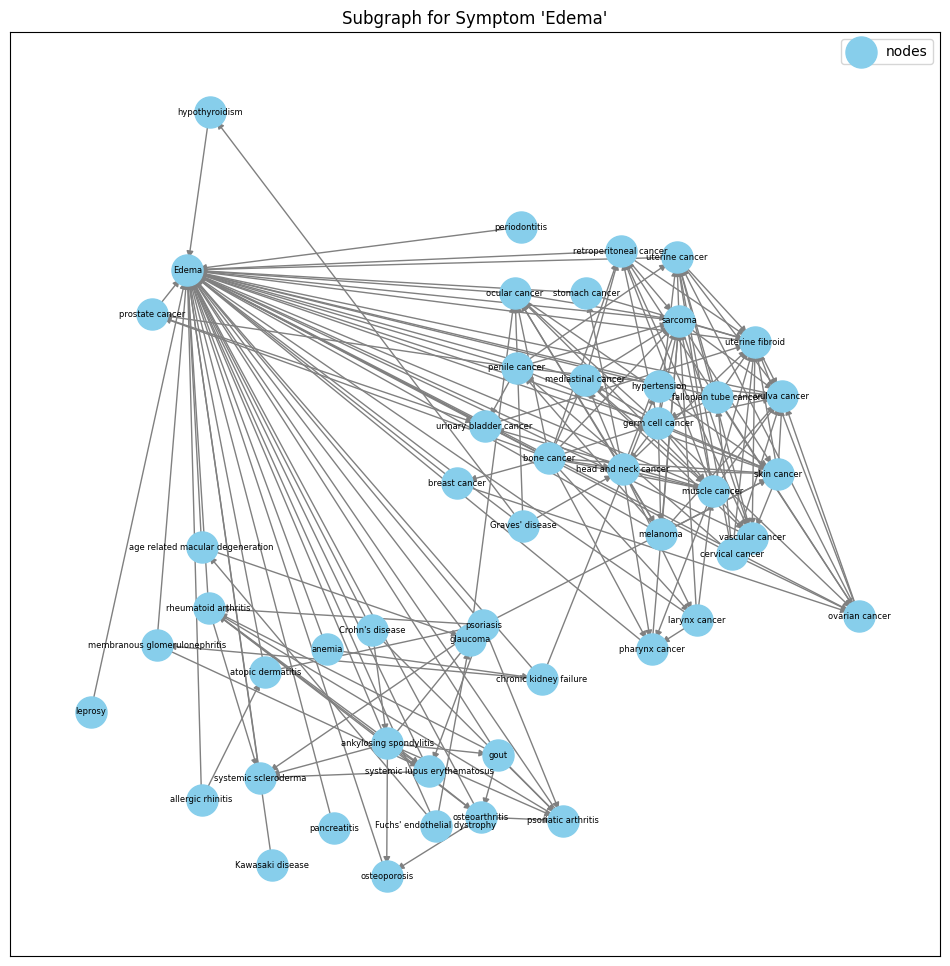

In [112]:
def extract_and_visualize_subgraph(G, symptom_name):
    # Find the node ID for the symptom
    symptom_id = next((node for node, attrs in G.nodes(data=True) if attrs.get('name') == symptom_name and attrs.get('kind') == 'Symptom'), None)
    
    if not symptom_id:
        print(f"No symptom found with the name '{symptom_name}'.")
        return

    # Get the subgraph for "Edema" and its immediate neighbors
    neighbors = list(G.predecessors(symptom_id)) + list(G.successors(symptom_id))
    neighbors.append(symptom_id)  # Include "Edema" in the subgraph
    subgraph = G.subgraph(neighbors)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  # positions for all nodes
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(subgraph, pos, node_size=500, node_color='skyblue', label='nodes')
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='gray')
    nx.draw_networkx_labels(subgraph, pos, labels={n: G.nodes[n]['name'] for n in subgraph.nodes()}, font_size=6)  # Smaller font size
    plt.title("Subgraph for Symptom 'Edema'")
    plt.legend()
    plt.show()

# Assuming H is your directed graph
extract_and_visualize_subgraph(H, "Edema")



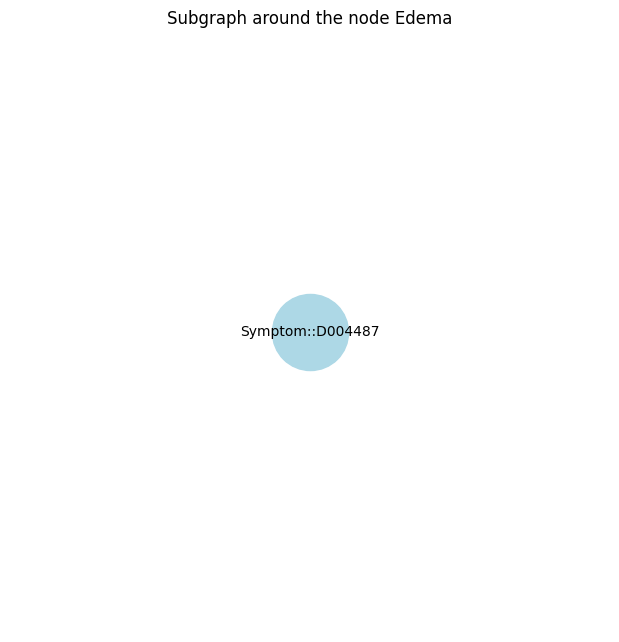

In [113]:
def plot_graph_section(G, central_node, radius=1):
    # Draw the graph with a specific node and its neighbors within a certain radius
    ego_graph = nx.ego_graph(G, central_node, radius=radius)
    pos = nx.spring_layout(ego_graph)
    plt.figure(figsize=(6, 6))
    nx.draw(ego_graph, pos, node_color='lightblue', with_labels=True, node_size=3000, font_size=10)
    plt.title(f"Subgraph around the node {G.nodes[central_node]['name']}")
    plt.show()

# Example usage, assuming you have the node ID for 'Edema'
symptom_id = next((node for node, attrs in G.nodes(data=True) if attrs.get('name') == 'Edema'), None)
if symptom_id:
    plot_graph_section(H, symptom_id)
else:
    print("Edema not found in the graph.")